# Guide
First we design some diagrams to see the movement between clusters among the different hours, the idea behind this is check visually if there is a pattern depending the hour.

After build LogistricRegresion that predict if exist at least one trip or not. → The model predicts no trips to minimize the error becouse there are much more data with 0 data.

The prediction of this models (after balance the data) are so bad.


# Preconfiguration
To execute - First create a service account and save in Google Drive, after change next data

In [ ]:
#Modify after MyDrive providing folders and file name
service_account_location = "drive/MyDrive/Ideas/movilidad/vacio-276411-service_account_for_colab.json"

# Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#Imports for matplotlib animation
from matplotlib import rc
rc('animation', html='jshtml')
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

In [ ]:
#BIGQUERY IMPORTS
from google.cloud import bigquery #For bigquerycredentials
from google.oauth2 import service_account #For credentials


##Mount access to Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#Set credentials as global
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= service_account_location 

# Construct a BigQuery client object.
client = bigquery.Client()

Mounted at /content/drive


# Get data

In [ ]:
query = """
SELECT 
    latitude_start_r,
    longitude_start_r,
    hour,
    CASE WHEN trips >0 THEN True ELSE  False END AS  exist_trip  
  FROM `vacio-276411.mainDataset.V2_model_data_latlon2_hour_trips_MADRID`
"""
df_classification = client.query(query).to_dataframe()

In [ ]:
##Convert latitude and longitude to number
df_classification['latitude_start_r'] = df_classification['latitude_start_r'].astype(str).astype(float)
df_classification['longitude_start_r'] = df_classification['longitude_start_r'].astype(str).astype(float)

In [ ]:
df_classification.dtypes

latitude_start_r     float64
longitude_start_r    float64
hour                   int64
exist_trip              bool
dtype: object

In [ ]:
df_classification

latitude_start_r  longitude_start_r  hour  exist_trip
0                  40.48              -3.69     0       False
1                  40.48              -3.69     1       False
2                  40.48              -3.69     2       False
3                  40.48              -3.69     3       False
4                  40.48              -3.69     4       False
...                  ...                ...   ...         ...
289291             40.54              -3.69    19       False
289292             40.54              -3.69    20       False
289293             40.54              -3.69    21       False
289294             40.54              -3.69    22       False
289295             40.54              -3.69    23       False

[289296 rows x 4 columns]

### Visualize data

## Pevius

In [ ]:
df_classification_mean_trips = df_classification
df_classification_mean_trips['exist_trip_number'] = df_classification_mean_trips['exist_trip'] == 1
df_classification_mean_trips.head(100)

latitude_start_r  longitude_start_r  hour  exist_trip  exist_trip_number
0              40.48              -3.69     0       False              False
1              40.48              -3.69     1       False              False
2              40.48              -3.69     2       False              False
3              40.48              -3.69     3       False              False
4              40.48              -3.69     4       False              False
..               ...                ...   ...         ...                ...
95             40.48              -3.69    23       False              False
96             40.48              -3.69     0       False              False
97             40.48              -3.69     1       False              False
98             40.48              -3.69     2       False              False
99             40.48              -3.69     3       False              False

[100 rows x 5 columns]

In [ ]:
df_classification_mean_trips = df_classification.groupby(["latitude_start_r","longitude_start_r","hour"])["exist_trip"].sum().astype(int).reset_index()
df_classification_mean_trips.head(100)

latitude_start_r  longitude_start_r  hour  exist_trip
0              40.36              -3.71     0           0
1              40.36              -3.71     1           0
2              40.36              -3.71     2           0
3              40.36              -3.71     3           0
4              40.36              -3.71     4           0
..               ...                ...   ...         ...
95             40.38              -3.60    23           0
96             40.39              -3.70     0           3
97             40.39              -3.70     1           4
98             40.39              -3.70     2           3
99             40.39              -3.70     3           5

[100 rows x 4 columns]

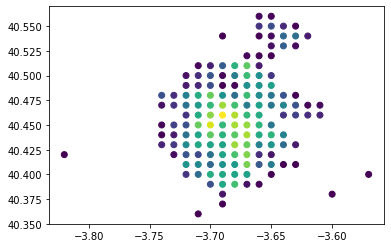

In [ ]:
df_classification_filter_hour = df_classification_mean_trips[ df_classification_mean_trips.hour==13 ]
plt.scatter(df_classification_filter_hour['longitude_start_r'], df_classification_filter_hour['latitude_start_r'], c =df_classification_filter_hour['exist_trip'])

## Animation

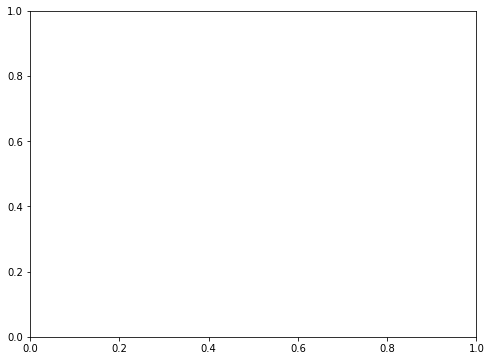

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()

In [ ]:
def frame(w):
    ax.clear()
    global x,y
    df_classification_filter_hour = df_classification_mean_trips[ df_classification_mean_trips.hour==w ]
    x=df_classification_filter_hour['longitude_start_r']
    y=df_classification_filter_hour['latitude_start_r']

    #plt.title("Brownian Motion")
    ax.set_title('Hora ' + str(w) )
    ax.set_xlabel('X(t)')
    ax.set_xlim(-3.9,-3.5)
    ax.set_ylabel('Y(t)')
    ax.set_ylim(40.3,40.6)
    plot=ax.scatter(x, y, c=df_classification_filter_hour['exist_trip'])
    return plot

In [ ]:
anim = animation.FuncAnimation(fig, frame, frames=24, blit=False, repeat=True, interval=500, repeat_delay=2000)

In [ ]:
anim

With the upper animation we see that could be a distribution depending on the hour and location

## Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df_classification[['latitude_start_r','longitude_start_r','hour']]
y = df_classification['exist_trip']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [ ]:
df_check_model1 = pd.DataFrame({'original':y_test, 'prediction': predictions})
df_check_model1

original  prediction
255332     False       False
36051      False       False
20160      False       False
683        False       False
121040      True       False
...          ...         ...
288166     False       False
72686       True       False
152899     False       False
128297     False       False
123648     False       False

[72324 rows x 2 columns]

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

print(cm)

[[56078     0]
 [16246     0]]


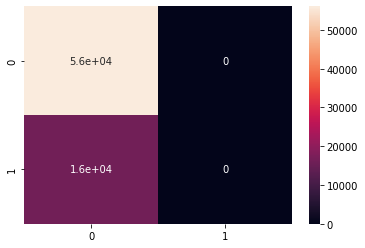

In [ ]:
import seaborn as sns 

sns.heatmap(cm, annot = True)

In [ ]:
from collections import Counter
print(Counter(y_test))
print(Counter(predictions))

Counter({False: 56078, True: 16246})
Counter({False: 72324})


As we can see the model estimate all the situations as False becouse there are much more False in the data than True so to optimece is only needed set all as false

## Balance data

In [ ]:
print(df_classification['exist_trip'].value_counts())
print(df_classification['exist_trip'].value_counts()[False] /df_classification['exist_trip'].value_counts()[True])

False    224420
True      64876
Name: exist_trip, dtype: int64
3.459214501510574


In [ ]:
#Duplicate true rows until has the same true rows than false
df_classification_balanced = df_classification
for i in (range(1,10)):
  diference_rows = df_classification_balanced['exist_trip'].value_counts()[False] - df_classification_balanced['exist_trip'].value_counts()[True]
  print(diference_rows)
  if(diference_rows ==0 ):
    break
  if(diference_rows > df_classification_balanced['exist_trip'].value_counts()[True]):
    df_classification_balanced = pd.concat([df_classification_balanced, (df_classification_balanced[df_classification_balanced['exist_trip'] == True]) ])
  else:
    df_classification_balanced = pd.concat([df_classification_balanced, (df_classification_balanced[df_classification_balanced['exist_trip'] == True][0:diference_rows])] )
print(df_classification_balanced['exist_trip'].value_counts())

159544
94668
0
False    224420
True     224420
Name: exist_trip, dtype: int64


In [ ]:
#Train model
X = df_classification_balanced[['latitude_start_r','longitude_start_r','hour']]
y = df_classification_balanced['exist_trip']

X_train, X_test, y_train, y_test = train_test_split(X, y)

lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [ ]:
df_check_model1 = pd.DataFrame({'original':y_test, 'prediction': predictions})
df_check_model1

original  prediction
81024      False       False
3936       False       False
246689      True        True
265900      True       False
111561      True        True
...          ...         ...
20068      False       False
115354     False       False
79647      False       False
159119     False        True
133882      True       False

[112210 rows x 2 columns]

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

print(cm)

[[29405 26714]
 [25529 30562]]


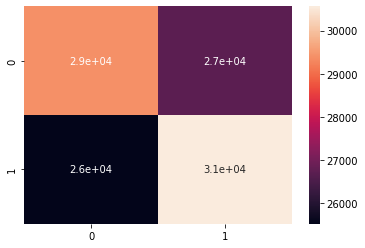

In [ ]:
import seaborn as sns 

sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import f1_score

print("F1 is a good default choice because it combines both precission and recall:")
print(f1_score(y_test, predictions))

F1 is a good default choice because it combines both precission and recall:
0.5391692467825735


As we can see the model is so bad, the half of items are bad estimated

## Balanced data with tree

In [ ]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()

#Train model
X = df_classification_balanced[['latitude_start_r','longitude_start_r','hour']]
y = df_classification_balanced['exist_trip']

X_train, X_test, y_train, y_test = train_test_split(X, y)

classifier.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

print(cm)

[[29247 26546]
 [25421 30996]]


No, same bad results

## Visualize diferents days

In [ ]:
#Add date to dataset
query = """
SELECT 
    latitude_start_r,
    longitude_start_r,
    hour,
    date,
    CASE WHEN trips >0 THEN True ELSE  False END AS  exist_trip  
  FROM `vacio-276411.mainDataset.V2_model_data_latlon2_hour_trips_MADRID`
"""
df_with_date = client.query(query).to_dataframe()


In [ ]:
#Convert date colum to datetime type
df_with_date["date"] = pd.to_datetime(df_with_date["date"])
##Convert latitude and longitude to number
df_with_date['latitude_start_r'] = df_with_date['latitude_start_r'].astype(str).astype(float)
df_with_date['longitude_start_r'] = df_with_date['longitude_start_r'].astype(str).astype(float)

In [ ]:
df_with_date.dtypes

latitude_start_r            float64
longitude_start_r           float64
hour                          int64
date                 datetime64[ns]
exist_trip                     bool
dtype: object

In [ ]:
#Change date to day of year and rest 162 becouse 162 is the first day of data
df_with_date["dayofyear"] = df_with_date["date"].apply(lambda x: (int(x.strftime('%j'))- 162) ) 


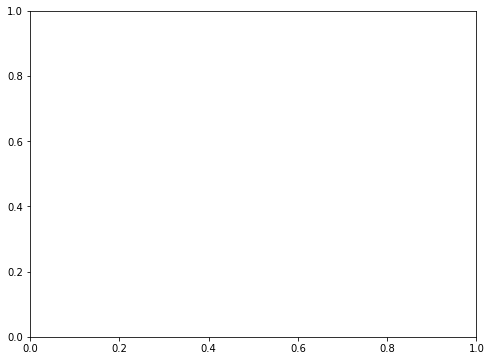

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()

In [ ]:
def frame(w):
    ax.clear()
    global x,y
    df_with_date_one_hour = df_with_date[df_with_date['hour'] == 14]
    df_classification_filter_hour = df_with_date_one_hour[ df_with_date_one_hour.dayofyear==w ]
    x=df_classification_filter_hour['longitude_start_r']
    y=df_classification_filter_hour['latitude_start_r']

    #plt.title("Brownian Motion")
    ax.set_title(' 14:00 - Day of data ' + str(w) )
    ax.set_xlabel('X(t)')
    ax.set_xlim(-3.9,-3.5)
    ax.set_ylabel('Y(t)')
    ax.set_ylim(40.3,40.6)
    plot=ax.scatter(x, y, c=df_classification_filter_hour['exist_trip'])
    return plot

In [ ]:
anim = animation.FuncAnimation(fig, frame, frames=70, blit=False, repeat=True, interval=500, repeat_delay=2000)

In [ ]:
anim

Same at 4:00

In [ ]:
def frame(w):
    ax.clear()
    global x,y
    df_with_date_one_hour = df_with_date[df_with_date['hour'] == 4]
    df_classification_filter_hour = df_with_date_one_hour[ df_with_date_one_hour.dayofyear==w ]
    x=df_classification_filter_hour['longitude_start_r']
    y=df_classification_filter_hour['latitude_start_r']

    #plt.title("Brownian Motion")
    ax.set_title(' 14:00 - Day of data ' + str(w) )
    ax.set_xlabel('X(t)')
    ax.set_xlim(-3.9,-3.5)
    ax.set_ylabel('Y(t)')
    ax.set_ylim(40.3,40.6)
    plot=ax.scatter(x, y, c=df_classification_filter_hour['exist_trip'])
    return plot

anim = animation.FuncAnimation(fig, frame, frames=70, blit=False, repeat=True, interval=500, repeat_delay=2000)

In [ ]:
anim